|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:330px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg" width="300"/></div>|
|---|---|--:|


# Convergence Analysis: Disc with a hole

For many typical engineering problems that need to be solved using numerical techniques, convergence plays a decisive role. Obtaining an assertion about the accuracy of the solution e.g. displacements or stresses, the minimum refinement of the mesh that is required to make sure that the results of the numerical analysis are not affected by changing the size of the mesh, is detected. 

In this paper the convergence in stress and displacement values for the disc with hole are analysed and compared to each other. Further explanations and calculations are based on fundamentals about the analytical and numerical solution from the paper "Linear_Disc_with_hole.ipynb". For a better access to the solutions used in this document, it is recommended to read through the previously mentioned Python script first.


For the consideration of the stress and displacement convergence seven steps of mesh refinement, described by an index parameter, are used. In the table below are listed each step of refinement with the corresponding edge length which is considered representative of the cell size.

$$
\begin{aligned}
&\begin{array}{cccc}
\text {Refinement Index} & \text {Cell Size [cm]} \\
\hline 8 & 1,429 \\
16 & 0,667 \\
24 & 0,435 \\
40 & 0,256 \\
60 & 0,169 \\
80 & 0,127 \\
240 & 0,042 \\
\end{array}
\end{aligned}
$$

In [3]:
# directory "out" will contain all data that we produce
#! mkdir -p out

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

#Some plot settings
plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = (8, 6)

In [5]:
# This list contains all parameters for the
# different meshes we create
STUDY_indices = [ 8, 16, 24, 40, 60, 80, 240 ]

# NOTE: I'll prefix all global variables that are of interest in
# the entire notebook with "STUDY_"

# With this parameter the length of one axis of the square plate is defined
STUDY_mesh_size = 20

In [6]:
# NOTE: Good function names are very important!
def read_last_timestep_mesh(study_idx):
    reader = pv.PVDReader(f"out/disc_with_hole_idx_is_{study_idx}.pvd")
    reader.set_active_time_point(-1) # go to last timestep
    
    # NOTE: "mesh" is a local variable. Inside the function body we
    # we don't have to worry to overwrite global variables
    mesh = reader.read()[0]
    
    return mesh

def slice_along_line(mesh, start_point, end_point):
    line = pv.Line(start_point, end_point, resolution = 2)
    return mesh.slice_along_line(line)

# NOTE: This function now in principle works with the line meshes
# we extract from the whole mesh, and also with the whole mesh.
def get_sigma_polar_components(mesh):
    sig = mesh.point_data["sigma"]
    
    num_points = sig.shape[0]
    sig_rr = np.zeros(num_points)
    sig_tt = np.zeros(num_points)
    sig_rt = np.zeros(num_points)
    
    for pt_idx in range(num_points):
        sig_vec = sig[pt_idx, :]
        x = mesh.points[pt_idx,0]
        y = mesh.points[pt_idx,1]
        sig_polar = vec4_to_mat3x3polar(sig_vec, x, y)
        sig_rr[pt_idx] = sig_polar[0,0]
        sig_tt[pt_idx] = sig_polar[1,1]
        sig_rt[pt_idx] = sig_polar[0,1]
        
    return sig_rr, sig_tt, sig_rt

def get_sort_indices_and_distances_by_distance_from_origin_2D(mesh):
    xs = mesh.points[:, 0]
    ys = mesh.points[:, 1]
    dist_from_origin = np.hypot(xs, ys)
    indices_sorted = np.argsort(dist_from_origin)
    dist_sorted = dist_from_origin[indices_sorted]
    
    return indices_sorted, dist_sorted

# NOTE: I've split the error computation into parts for each component
# for better readability
def compute_abs_and_rel_stress_error_rr(sigmas_rr_num, rs, theta_degree):
    num_points = sigmas_rr_num.shape[0]
    f_abs_rr = np.zeros(num_points)
    f_rel_rr = np.zeros(num_points)
    
    for pt_idx in range(num_points):
        r = rs[pt_idx]
        
        # NOTE: It's usually a good idea to save intermediate results
        # in a local variable, even "small" results
        sigma_rr_ana = kirsch_sig_rr(10, r, theta_degree, 2)
        
        # NOTE: Such unit conversions " * 1000" are should better be avoided
        # or at least not scattered throughout the code/notebook
        sigma_rr_num = sigmas_rr_num[pt_idx] * 1000
        
        f_abs_rr[pt_idx] = sigma_rr_num - sigma_rr_ana
        
        if sigma_rr_ana == 0:
            f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / 1e-2
        else:
            f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / sigma_rr_ana
            
    return f_abs_rr, f_rel_rr
        
def compute_abs_and_rel_stress_error_rt(sigmas_rt_num, rs, theta_degree):
    num_points = sigmas_rt_num.shape[0]
    f_abs_rt = np.zeros(num_points)
    f_rel_rt = np.zeros(num_points)
    
    for pt_idx in range(num_points):
        r = rs[pt_idx]
        
        sigma_rt_ana = kirsch_sig_rt(10, r, theta_degree, 2)
        sigma_rt_num = sigmas_rt_num[pt_idx] * 1000
        
        f_abs_rt[pt_idx] = sigma_rt_num - sigma_rt_ana
        
        if sigma_rt_ana == 0:
            f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / 1e-2
        else:
            f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / sigma_rt_ana
       
    return f_abs_rt, f_rel_rt
        
def compute_abs_and_rel_stress_error_tt(sigmas_tt_num, rs, theta_degree):
    num_points = sigmas_tt_num.shape[0]
    f_abs_tt = np.zeros(num_points)
    f_rel_tt = np.zeros(num_points)
    
    for pt_idx in range(num_points):
        r = rs[pt_idx]
        
        sigma_tt_ana = kirsch_sig_tt(10, r, theta_degree, 2)
        sigma_tt_num = sigmas_tt_num[pt_idx] * 1000
        
        f_abs_tt[pt_idx] = sigma_tt_num - sigma_tt_ana
        
        if sigma_tt_ana == 0:
            f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / 1e-2
        else:
            f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / sigma_tt_ana
       
    return f_abs_tt, f_rel_tt

def compute_cell_size(idx):
    mesh = read_last_timestep_mesh(idx)
    pt1 = (19.999,0,0)
    pt2 = (19.999,20,0)
    line_mesh = slice_along_line(mesh, pt1, pt2)
    number = line_mesh.points.shape[0]-1               # number of cells along the right edge of the plate
    size = STUDY_mesh_size/number                      # height of plate divided by number of cells 
    return size

def resample_mesh_to_240_resolution(idx):
    mesh_fine = read_last_timestep_mesh(240)
    mesh_coarse = read_last_timestep_mesh(idx)
    return mesh_fine.sample(mesh_coarse)

#def compute_abs_and_rel_errors_form_mesh_240(idx):
    

## Create Gmsh meshes

To generate the grids and to enable the individual parameters to be adjusted from within this paper the script "mesh_quarter_of_rectangle_with_hole.py" is used. 
For the considered problem the parameter $a$ and $b$ which define the size of the rectangular quarter of the plate are set to a value of $20\, \text{cm}$. The radius of the central hole is regulated by the value of $r$, which is set at $r = 2\, \text{cm}$.

The arguments Nx, Ny, NR and Nr of the script describe the refinement of the mesh and are determined according to the regarded refinement indices. 

Parameter $R$ describes the area for a further refinement of the grid radially symmetrical to the hole. This additional refinement is needed for a better description of the increasing stress and strain gradients near the hole. Because the fine resolution of the mesh is only needed in the area around the hole, the size of $R$ is half the size of the plate.

In [7]:
import mesh_quarter_of_rectangle_with_hole

In [8]:
for idx in STUDY_indices:
    """
    a and b seem to be the sizes of the rectangular plate,
    r the hole radius, R an auxiliary radius
    the other parameters control the mesh resolution
    please check that, and maybe document in mesh_quarter_of_rectangle_with_hole.py
    """
    output_file = f"out/disc_with_hole_idx_is_{idx}.msh"
    mesh_quarter_of_rectangle_with_hole.run(output_file, a=STUDY_mesh_size, b=STUDY_mesh_size, r=2, R=0.5*STUDY_mesh_size, Nx=idx, Ny=idx, NR=idx, Nr=idx, P=1)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Circle)
Info    : [ 60%] Meshing curve 10 (Circle)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : [100%] Meshing curve 15 (Line)
Info    : Done meshing 1D (Wall 0.0027681s, CPU 0.002276s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 2 (Transfinite)
Info    : [ 40%] Meshing surface 3 (Transfinite)
Info    : [ 60%] Meshing surface 4 (Transfinite)
Info    : [ 80%] Meshing surface 5 (Transfinite)
Info    : Done meshing 2D (Wall 0.0065

## Transform to VTU meshes suitable for OGS

In [9]:
for idx in STUDY_indices:
    input_file = f"out/disc_with_hole_idx_is_{idx}.msh"
    
    # This strange code is needed, for now.
    !python /opt/conda/lib/python3.10/site-packages/msh2vtu/msh2vtu.py --ogs {input_file}

MeshIO 5.3.4 found, MSH2VTU was tested with MeshIO 5.3.8.
sys:1: UserWarning: Warning, out-dated MeshIO version. In case of errors watch for commented code fragments from previous versions in this script (msh2vtu).
##

Original mesh (read)
281 points in 3 dimensions; cells: 70 line, 245 quad; point_data=['gmsh:dim_tags']; cell_data=['gmsh:physical', 'gmsh:geometrical']; cell_sets=['Bottom', 'Right', 'Top', 'Left', 'Hole', 'Plate', 'gmsh:bounding_entities']
##
Detected mesh dimension: 2
##
Domain mesh (written)
281 points in 3 dimensions; cells: 245 quad; point_data=['original_node_number']; cell_data=['MaterialIDs']; cell_sets=[]
##
Boundary mesh (written)
70 points in 3 dimensions; cells: 70 line; point_data=['bulk_node_ids']; cell_data=['bulk_elem_ids']; cell_sets=[]
##
Submesh Bottom (written)
15 points in 3 dimensions; cells: 14 line; point_data=['bulk_node_ids']; cell_data=['bulk_elem_ids']; cell_sets=[]
##
Submesh Right (written)
15 points in 3 dimensions; cells: 14 line; point_d

## Visualize the meshes

To acquire a better sense of cell sizes and the additional refinement around the hole, the meshes of refinement indices 8 and 80 are visualised hereafter. 

In [10]:
import pyvista as pv
pv.set_plot_theme("document")
pv.set_jupyter_backend("static")

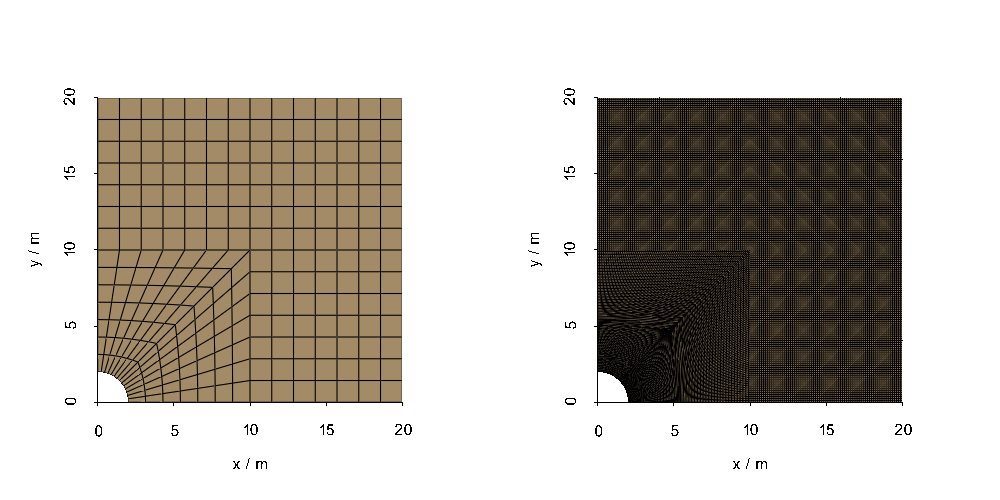

In [11]:
domain_8 = pv.read("out/disc_with_hole_idx_is_8_" + "domain.vtu")
domain_80 = pv.read("out/disc_with_hole_idx_is_80_" + "domain.vtu")

p = pv.Plotter(shape=(1, 2), border=False)
p.subplot(0,0)
p.add_mesh(domain_8, show_edges=True, show_scalar_bar=False, color=None, scalars=None)
p.view_xy()
p.show_bounds(ticks="outside", xlabel="x / m", ylabel="y / m")
p.camera.zoom(1.3)

p.subplot(0,1)
p.add_mesh(domain_80, show_edges=True, show_scalar_bar=False, color=None, scalars=None)
p.view_xy()
p.show_bounds(ticks="outside", xlabel="x / m", ylabel="y / m")
p.camera.zoom(1.3)
p.window_size = [1000,500]

p.show()

## Run OGS

In [12]:
from ogs6py import ogs

In [13]:
for idx in STUDY_indices:
    prj_file = f"disc_with_hole_idx_is_{idx}.prj"
    model = ogs.OGS(INPUT_FILE=prj_file, PROJECT_FILE=prj_file)
    model.run_model(logfile="out/ogs.log", args="-o out") # write output files to the "out" directory

OGS finished with project file disc_with_hole_idx_is_8.prj.
Execution took 2.5217549800872803 s
OGS finished with project file disc_with_hole_idx_is_16.prj.
Execution took 1.9315154552459717 s
OGS finished with project file disc_with_hole_idx_is_24.prj.
Execution took 3.0686843395233154 s
OGS finished with project file disc_with_hole_idx_is_40.prj.
Execution took 7.036077260971069 s
OGS finished with project file disc_with_hole_idx_is_60.prj.
Execution took 22.547306537628174 s
OGS finished with project file disc_with_hole_idx_is_80.prj.
Execution took 51.955302715301514 s
OGS finished with project file disc_with_hole_idx_is_240.prj.
Execution took 1628.5997660160065 s


## Error Analysis

### Comparison with analytical solution

The aim of the following steps is to receive statements about the approximation of the numerical solution for finer meshes to the analytical solution of Kirsch. Therefore, plots of the radial, tangential and shear stress distribution along the x-axis are generated. In addition to these visualisations, the absolute error of each step of refinement to the analytical solution is plotted for better interpretation of variations. 

A first perception that can be gained from the stress charts is that for the considered axis the stress distribution around the cavity converge to Kirsch´s Solution with decreasing size of the mesh cells. This decrease of the extrapolation errors can also be seen in the plots for the absolute error. With proximity to the cavity, the error values for finer meshes shrink more and more.

Another effect, that is particularly visible in the plots of $\sigma_{rr}$ and $\sigma_{\theta\theta}$ along the x-axis is an increasing convergence of the solutions for each refinement step to the solution for the finest mesh at the outer boundaries. The results of the numerical solution therefore do not converge against the analytical solution but against the numerical solution itself for very fine meshes. This problem is caused by the limitation of the plates geometry.   


For this reason, an error analysis against the analytical solution does not make sense. Instead, the individual numerical solutions are compared with a "pseudo" analytical solution. For this purpose, a numerical result with extremely fine mesh resolution (refinement index = 240) is generated.

In [14]:
def kirsch_sig_rr(sig,r,theta,a):
    return 0.5*sig*((1-a**2/r**2)+(1+3*np.power(a,4)/np.power(r,4)-4*a**2/r**2)*np.cos(2*np.pi*theta/180)) * np.heaviside(r+1e-7-a,1) 
    
def kirsch_sig_tt(sig,r,theta,a):
    return 0.5*sig*((1+a**2/r**2)-(1+3*np.power(a,4)/np.power(r,4))*np.cos(2*np.pi*theta/180)) * np.heaviside(r+1e-7-a,1)

def kirsch_sig_rt(sig,r,theta,a):
    return -0.5*sig*((1-3*np.power(a,4)/np.power(r,4)+2*a**2/r**2)*np.sin(2*np.pi*theta/180)) * np.heaviside(r+1e-7-a,1)

In [15]:
def vec4_to_mat3x3cart(vec4, xs, ys):
    theta = np.arctan2(ys, xs)
    
    m = np.zeros((3,3))
    m[0,0] = vec4[0]
    m[1,1] = vec4[1]
    m[2,2] = vec4[2]
    m[0,1] = vec4[3]
    m[1,0] = vec4[3]
    
    return np.matrix(m)

def vec4_to_mat3x3polar(vec4, xs, ys):     
    
    m_cart = vec4_to_mat3x3cart(vec4, xs, ys)
    
    theta = np.arctan2(ys, xs)

    rot = np.matrix(np.eye(3))
    rot[0,0] = np.cos(theta)
    rot[0,1] = -np.sin(theta)
    rot[1,0] = np.sin(theta)
    rot[1,1] = np.cos(theta)
    
    return rot.T * m_cart * rot

In [16]:
# NOTE: Here we'll collect all simulation results
# accessible via their idx value
# We'll be able to reuse/read them many times
# NOTE: Again, good variable names are important!
STUDY_num_result_xaxis_meshes_by_index = {}

for idx in STUDY_indices:
    mesh = read_last_timestep_mesh(idx)
    pt1 = (0,1e-6,0)
    pt2 = (10,1e-6,0)
    line_mesh = slice_along_line(mesh, pt1, pt2)
    
    # TODO: same for y axis and diagonal
    STUDY_num_result_xaxis_meshes_by_index[idx] = line_mesh

In [17]:
STUDY_num_result_yaxis_meshes_by_index = {}

for idx in STUDY_indices:
    mesh = read_last_timestep_mesh(idx)
    pt1 = (1e-6,0,0)
    pt2 = (1e-6,10,0)
    line_mesh = slice_along_line(mesh, pt1, pt2)
    
    STUDY_num_result_yaxis_meshes_by_index[idx] = line_mesh

In [18]:
STUDY_num_result_diagonal_meshes_by_index = {}

for idx in STUDY_indices:
    mesh = read_last_timestep_mesh(idx)
    pt1 = (1e-6,1e-6,0)
    pt2 = (28.28,28.28,0)
    line_mesh = slice_along_line(mesh, pt1, pt2)
    
    STUDY_num_result_diagonal_meshes_by_index[idx] = line_mesh

### Stress distribution along the x-axis

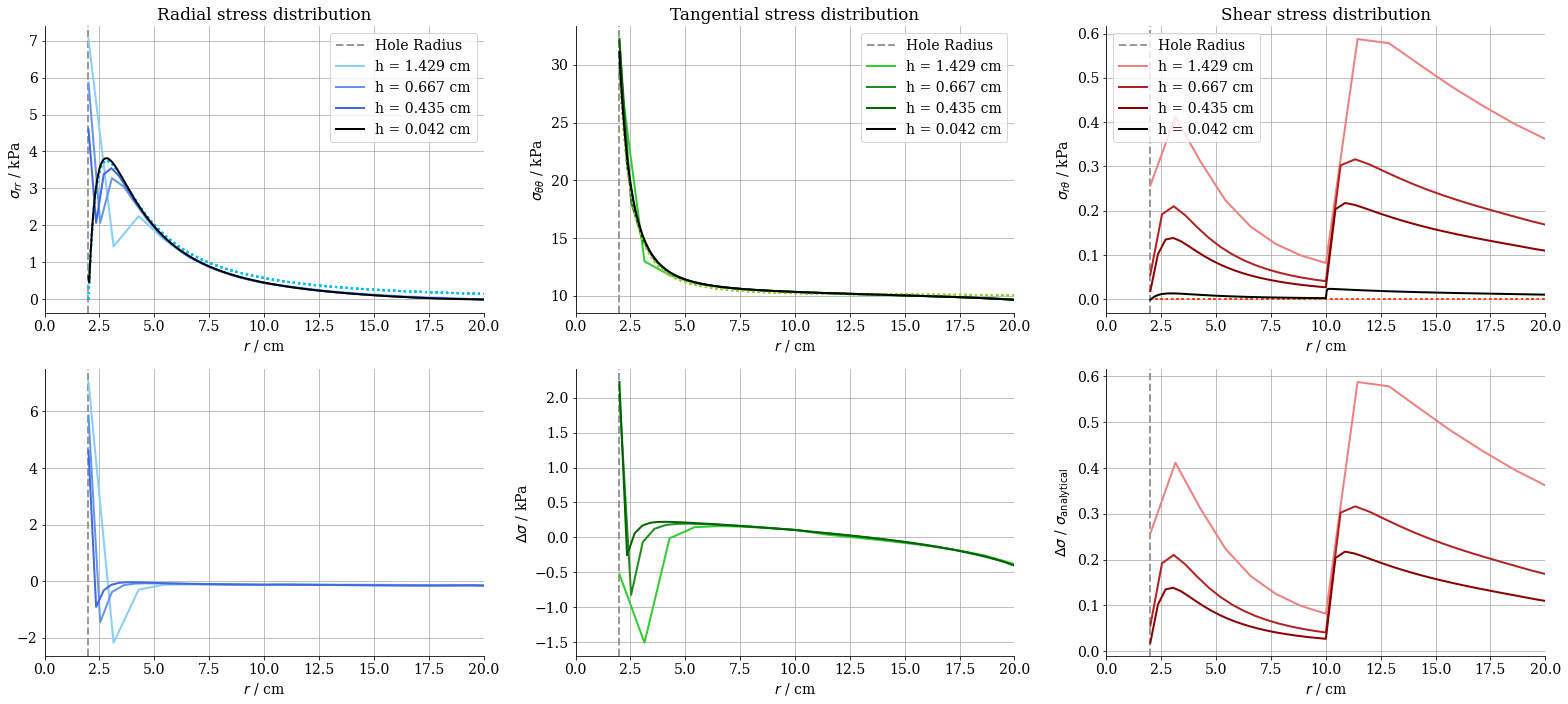

In [19]:
# NOTE: This function just encapsulates everything such that we
# don't use so many global variables
def plot_stress_distribution_along_xaxis():
    ### Step 1: Compute data ##########################################
    # NOTE: Separating data computation and visualization is usually a good
    # idea
    
    # These variables will hold the error data for all STUDY_indices
    f_abs_rr = {}
    f_abs_tt = {}
    f_abs_rt = {}
    
    #Plot setup
    fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(22,10))
    for i in range (2):
        for j in range (3):
            ax[i][j].axvline(2, color="0.6", linestyle = "--", label = "Hole Radius")
            ax[i][j].grid(True)
            ax[i][j].set(xlim=(0,STUDY_mesh_size))
            ax[i][j].set_xlabel('$r$ / cm')
            ax[i][1].set_ylabel('$\Delta\\sigma$ / kPa')
            ax[i][2].set_ylabel('$\Delta\\sigma$ / $\sigma_{\mathrm{analytical}}$')
    
    # NOTE: Iterating over the global STUDY_indices list ensures that
    # we always use the same set of indices and don't accidentally
    # forget to change them in one place during our work
    for idx in STUDY_indices:
        # we use the line mesh we extracted before
        line_mesh = STUDY_num_result_xaxis_meshes_by_index[idx]

        sig_rr, sig_tt, sig_rt = get_sigma_polar_components(line_mesh)

        indices_sorted, dist_sorted = get_sort_indices_and_distances_by_distance_from_origin_2D(line_mesh)

        # sort sigma by distance from origin
        sig_rr_sorted = sig_rr[indices_sorted]
        sig_tt_sorted = sig_tt[indices_sorted]
        sig_rt_sorted = sig_rt[indices_sorted]

        # compute errors
        f_abs_rr, f_rel_rr = compute_abs_and_rel_stress_error_rr(
            sig_rr_sorted, dist_sorted, -90)
        f_abs_tt, f_rel_tt = compute_abs_and_rel_stress_error_tt(
            sig_tt_sorted, dist_sorted, -90)
        f_abs_rt, f_rel_rt = compute_abs_and_rel_stress_error_rt(
            sig_rt_sorted, dist_sorted, -90)
        
        ### Step 2: Plot data ##############################################
    
        ax[0][0].set_ylabel('$\\sigma_{rr}$ / kPa')
        ax[0][1].set_ylabel('$\\sigma_{\\theta\\theta}$ / kPa')
        ax[0][2].set_ylabel('$\\sigma_{r\\theta}$ / kPa')
        

        # analytical results
        r = np.linspace(2,STUDY_mesh_size,1000)
        ax[0][0].plot(r, kirsch_sig_rr(10,r,-90,2), color = "deepskyblue", linestyle = ":") #, label = "$\sigma_{rr,\mathrm{analytical}}$")
        ax[0][1].plot(r, kirsch_sig_tt(10,r,-90,2), color = "yellowgreen", linestyle = ":") #, label = "$\sigma_{\\theta\\theta,\mathrm{analytical}}$")
        ax[0][2].plot(r, kirsch_sig_rt(10,r,-90,2), color = "orangered", linestyle = ":") #, label = "$\sigma_{r\\theta,\mathrm{analytical}}$")

        # numerical results

        # NOTE: Using hard coded indices (8, 16, 24) here makes the code a bit harder to change.
        # I know, it's currently necessary for assigning colors, but in a clean up step at the very end,
        # we maybe can avoid it (or we are just happy that everything runs and looks nice and leave it as it is)
        if idx == 8:
            # TODO Maybe plotting the analytical results again is not necessary
            ax[0][0].plot(dist_sorted, sig_rr_sorted*1000, color = "lightskyblue", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[0][1].plot(dist_sorted, sig_tt_sorted*1000, color = "limegreen", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[0][2].plot(dist_sorted, sig_rt_sorted*1000, color = "lightcoral", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[1][0].plot(dist_sorted, f_abs_rr, color = "lightskyblue")
            ax[1][1].plot(dist_sorted, f_abs_tt, color = "limegreen")
            ax[1][2].plot(dist_sorted, f_abs_rt, color = "lightcoral")
            
        if idx == 16:
            ax[0][0].plot(dist_sorted, sig_rr_sorted*1000, color = "cornflowerblue", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[0][1].plot(dist_sorted, sig_tt_sorted*1000, color = "forestgreen", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[0][2].plot(dist_sorted, sig_rt_sorted*1000, color = "firebrick", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[1][0].plot(dist_sorted, f_abs_rr, color = "cornflowerblue")
            ax[1][1].plot(dist_sorted, f_abs_tt, color = "forestgreen")
            ax[1][2].plot(dist_sorted, f_abs_rt, color = "firebrick")
            
        if idx == 24:
            ax[0][0].plot(dist_sorted, sig_rr_sorted*1000, color = "royalblue", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[0][1].plot(dist_sorted, sig_tt_sorted*1000, color = "darkgreen", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[0][2].plot(dist_sorted, sig_rt_sorted*1000, color = "darkred", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[1][0].plot(dist_sorted, f_abs_rr, color = "royalblue")
            ax[1][1].plot(dist_sorted, f_abs_tt, color = "darkgreen")
            ax[1][2].plot(dist_sorted, f_abs_rt, color = "darkred")
            
        if idx == 240:
            ax[0][0].plot(dist_sorted, sig_rr_sorted*1000, color = "black", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[0][1].plot(dist_sorted, sig_tt_sorted*1000, color = "black", label = f"h = {compute_cell_size(idx):.3f} cm")
            ax[0][2].plot(dist_sorted, sig_rt_sorted*1000, color = "black", label = f"h = {compute_cell_size(idx):.3f} cm") 

        # final plot settings    
        for i in range (3):
            ax[0][i].legend()

        ax[0][0].set_title('Radial stress distribution')
        ax[0][1].set_title('Tangential stress distribution')
        ax[0][2].set_title('Shear stress distribution')

        fig.tight_layout()

plot_stress_distribution_along_xaxis()

## Comparison with "pseudo" analytical solution

As described before the numerical solutions for each refinement step are compared to the solution for the finest regarded refinement index of 240 in the following section. Although the approximation is already clear from the previous plots of the stress curves along the x axis, mathematical norms are used hereafter for a better representation and interpretation of the relationship.


### Norm Plots

To quantify the total error of a numerical calculation, various error norms can be used:

\begin{align}
    \ell_{2}=|w|=\sqrt{\sum_{i=0}^N (w_{i}-u_{i})^2}
\\
    RMS =\sqrt{\frac{\sum_{i=0}^N (w_{i}-u_{i})^2}{N}}
\\
L_{2}=||w||=\sqrt{\int_{\Omega} (w(x)-u(x))^2 dx}
\end{align}

The $\ell_{2}$ norm or Euclidean norm is the square root of the sum of the squared absolute errors at each point of the mesh.  

The root mean square ($RMS$) is calculated similarly. Here, however, the influence of the number of points is taken into account by dividing by the square root of the number of points.

The $L_{2}$ norm as Integral norm represents a generalization of the $\ell_{2}$ norm for continuous functions. While the Euclidean norm determines the values for individual mesh nodes, the Integral norm considers the course over the entire mesh. Therefor an advantage of the $L_{2}$ norm is, that big elements are considered with a higher impact than small ones, which produces more homogeneous results. 

The following plots represent the development of the Euclidean and Integral norm and $RMS$ for the refinement of the mesh. How fast the considered element converge is expressed by the gradient of the linear curves in the plot. 
First the detailed discussed error norms for the stresses are visualised and in addition to them the norms for the associated displacements to draw conclusions about the quality of convergence. 

A main statement that can be made is that the solution for the displacements converge significantly more rapid than for the stresses. The approach of the displacement values for the meshes with decreasing cell sizes to the finest mesh with refinement index 240 is much better than for the regarded stresses. 


In [20]:
from vtkmodules.vtkFiltersParallel import vtkIntegrateAttributes

In [21]:
def integrate_mesh_attributes(mesh):
    integrator = vtkIntegrateAttributes()
    integrator.SetInputData(mesh)
    integrator.Update()
    return pv.wrap(integrator.GetOutputDataObject(0)) # that is an entire mesh with one point and one cell

In [22]:
def compute_ell_2_norm_sigma(idx):
    mesh_coarse = read_last_timestep_mesh(idx)
    mesh_fine = read_last_timestep_mesh(240)
    mesh_resampled_to_240_resolution = mesh_fine.sample(mesh_coarse)
    
    sig_rr, sig_tt, sig_rt = get_sigma_polar_components(mesh_resampled_to_240_resolution)
    sig_rr_240, sig_tt_240, sig_rt_240 = get_sigma_polar_components(mesh_fine)
    
    list_rr = (sig_rr_240 - sig_rr)**2
    list_tt = (sig_tt_240 - sig_tt)**2
    list_rt = (sig_rt_240 - sig_rt)**2
    
    l2_rr = np.sqrt(sum(list_rr))
    l2_tt = np.sqrt(sum(list_tt))
    l2_rt = np.sqrt(sum(list_rt))
    
    return l2_rr, l2_tt, l2_rt

In [23]:
def compute_ell_2_norm_displacement(idx):
    mesh_coarse = read_last_timestep_mesh(idx)
    mesh_fine = read_last_timestep_mesh(240)
    mesh_resampled_to_240_resolution = mesh_fine.sample(mesh_coarse)
    
    dis = mesh_resampled_to_240_resolution.point_data["displacement"]
    dis_x = dis[:,0]
    dis_y = dis[:,1]
    
    dis_240 = mesh_fine.point_data["displacement"]
    dis_x_240 = dis_240[:,0]
    dis_y_240 = dis_240[:,1]
    
    list_x = (dis_x_240 - dis_x)**2
    list_y = (dis_y_240 - dis_y)**2
    
    l2_x = np.sqrt(sum(list_x))
    l2_y = np.sqrt(sum(list_y))
    
    return l2_x, l2_y

In [24]:
def compute_root_mean_square_sigma(idx):
    mesh_coarse = read_last_timestep_mesh(idx)
    mesh_fine = read_last_timestep_mesh(240)
    mesh_resampled_to_240_resolution = mesh_fine.sample(mesh_coarse)
    
    points = mesh_resampled_to_240_resolution.point_data["sigma"].shape[0] 
    
    sig_rr, sig_tt, sig_rt = get_sigma_polar_components(mesh_resampled_to_240_resolution)
    sig_rr_240, sig_tt_240, sig_rt_240 = get_sigma_polar_components(mesh_fine)
    
    list_rr = (sig_rr_240 - sig_rr)**2
    list_tt = (sig_tt_240 - sig_tt)**2
    list_rt = (sig_rt_240 - sig_rt)**2
    
    l2_rr = np.sqrt(sum(list_rr))
    l2_tt = np.sqrt(sum(list_tt))
    l2_rt = np.sqrt(sum(list_rt))
    
    return l2_rr/np.sqrt(points), l2_tt/np.sqrt(points), l2_rt/np.sqrt(points)

In [25]:
def compute_root_mean_square_displacement(idx):
    mesh_coarse = read_last_timestep_mesh(idx)
    mesh_fine = read_last_timestep_mesh(240)
    mesh_resampled_to_240_resolution = mesh_fine.sample(mesh_coarse)
    
    points = mesh_resampled_to_240_resolution.point_data["sigma"].shape[0] 
    
    dis = mesh_resampled_to_240_resolution.point_data["displacement"]
    dis_x = dis[:,0]
    dis_y = dis[:,1]
    
    dis_240 = mesh_fine.point_data["displacement"]
    dis_x_240 = dis_240[:,0]
    dis_y_240 = dis_240[:,1]
    
    list_x = (dis_x_240 - dis_x)**2
    list_y = (dis_y_240 - dis_y)**2
    
    l2_x = np.sqrt(sum(list_x))
    l2_y = np.sqrt(sum(list_y))
    
    return l2_x/np.sqrt(points), l2_y/np.sqrt(points)

In [26]:
def compute_Ell_2_norm_sigma(idx):
    mesh_coarse = read_last_timestep_mesh(idx)
    mesh_fine = read_last_timestep_mesh(240)
    mesh_resampled_to_240_resolution = mesh_fine.sample(mesh_coarse)
    
    points = mesh_resampled_to_240_resolution.point_data["sigma"].shape[0]
    
    sig_rr, sig_tt, sig_rt = get_sigma_polar_components(mesh_resampled_to_240_resolution)
    sig_rr_240, sig_tt_240, sig_rt_240 = get_sigma_polar_components(mesh_fine)
    
    list_rr = np.zeros([points])
    list_tt = np.zeros([points])
    list_rt = np.zeros([points])

    for i in range (points):
        list_rr[i] = (sig_rr_240[i] - sig_rr[i])**2
        list_tt[i] = (sig_tt_240[i] - sig_tt[i])**2
        list_rt[i] = (sig_rt_240[i] - sig_rt[i])**2
        
    # We add the squared differences as new point data to the mesh
    mesh_resampled_to_240_resolution.point_data["diff_rr_squared"] = list_rr
    mesh_resampled_to_240_resolution.point_data["diff_tt_squared"] = list_tt
    mesh_resampled_to_240_resolution.point_data["diff_rt_squared"] = list_rt
    
    # this will integrate all fields at once, so you can add the tt and rt components above and call this only once.
    integration_result_mesh = integrate_mesh_attributes(mesh_resampled_to_240_resolution)
    
    # new: integral norm, the index [0] accesses the data of the single point contained in the mesh
    L2_rr = np.sqrt(integration_result_mesh.point_data["diff_rr_squared"][0])
    L2_tt = np.sqrt(integration_result_mesh.point_data["diff_tt_squared"][0])
    L2_rt = np.sqrt(integration_result_mesh.point_data["diff_rt_squared"][0])
    
    return L2_rr, L2_tt, L2_rt

In [27]:
def compute_Ell_2_norm_displacement(idx):
    mesh_coarse = read_last_timestep_mesh(idx)
    mesh_fine = read_last_timestep_mesh(240)
    mesh_resampled_to_240_resolution = mesh_fine.sample(mesh_coarse)
    
    points = mesh_resampled_to_240_resolution.point_data["sigma"].shape[0]
    
    dis = mesh_resampled_to_240_resolution.point_data["displacement"]
    dis_x = dis[:,0]
    dis_y = dis[:,1]
    
    dis_240 = mesh_fine.point_data["displacement"]
    dis_x_240 = dis_240[:,0]
    dis_y_240 = dis_240[:,1]
    
    list_x = np.zeros([points])
    list_y = np.zeros([points])

    for i in range (points):
        list_x[i] = (dis_x_240[i] - dis_x[i])**2
        list_y[i] = (dis_y_240[i] - dis_y[i])**2
        
    # We add the squared differences as new point data to the mesh
    mesh_resampled_to_240_resolution.point_data["diff_x_squared"] = list_x
    mesh_resampled_to_240_resolution.point_data["diff_y_squared"] = list_y
    
    # this will integrate all fields at once, so you can add the tt and rt components above and call this only once.
    integration_result_mesh = integrate_mesh_attributes(mesh_resampled_to_240_resolution)
    
    # new: integral norm, the index [0] accesses the data of the single point contained in the mesh
    L2_x = np.sqrt(integration_result_mesh.point_data["diff_x_squared"][0])
    L2_y = np.sqrt(integration_result_mesh.point_data["diff_y_squared"][0])
    
    return L2_x, L2_y

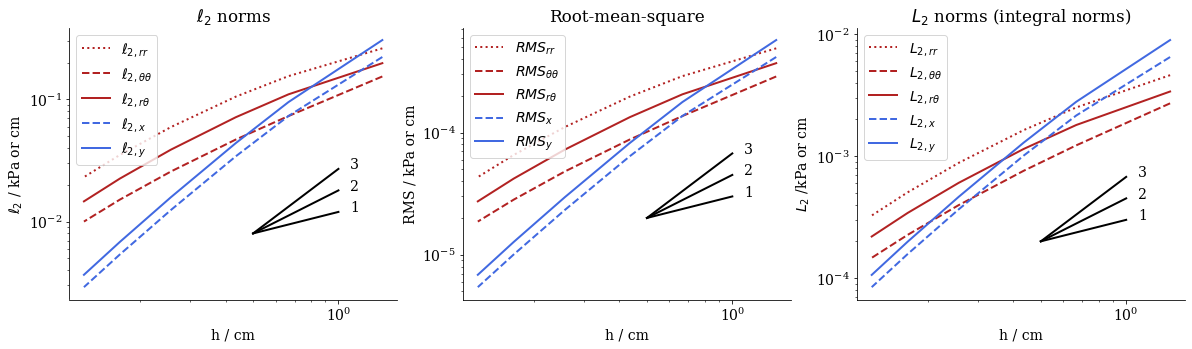

In [29]:
# empty dictionaries
size = {}
l2_rr = {}
l2_tt = {}
l2_rt = {}
rms_rr = {}
rms_tt = {}
rms_rt = {}
L2_rr = {}
L2_tt = {}
L2_rt = {}
l2_x = {}
l2_y = {}
rms_x = {}
rms_y = {}
L2_x = {}
L2_y = {}

for idx in STUDY_indices:
    if idx != 240:
        l2_rr[idx], l2_tt[idx], l2_rt[idx] = compute_ell_2_norm_sigma(idx)
        rms_rr[idx], rms_tt[idx], rms_rt[idx] = compute_root_mean_square_sigma(idx)
        L2_rr[idx], L2_tt[idx], L2_rt[idx] = compute_Ell_2_norm_sigma(idx)
        l2_x[idx], l2_y[idx] = compute_ell_2_norm_displacement(idx)
        rms_x[idx], rms_y[idx] = compute_root_mean_square_displacement(idx)
        L2_x[idx], L2_y[idx] = compute_Ell_2_norm_displacement(idx)
        size[idx] = compute_cell_size(idx)

h = np.linspace(size[80],size[8],1000)
k = np.linspace(0.5,1, 2)

fig, ax = plt.subplots(ncols=3, figsize = (20,5))

ax[0].plot(size.values(), l2_rr.values(), color = "firebrick", linestyle = ":", label = "$\ell_{2, rr}$")
ax[0].plot(size.values(), l2_tt.values(), color = "firebrick", linestyle = "--", label = "$\ell_{2, \\theta\\theta}$")
ax[0].plot(size.values(), l2_rt.values(), color = "firebrick", label = "$\ell_{2, r\\theta}$")
ax[0].plot(size.values(), l2_x.values(), color = "royalblue", linestyle = "--", label = "$\ell_{2, x}$")
ax[0].plot(size.values(), l2_y.values(), color = "royalblue", label = "$\ell_{2, y}$")
#ax[0].plot(h,0.15*h**1.1, color = "black")
ax[0].plot(k, 0.008*(k+0.5)**1, color = "black")
ax[0].plot(k, 0.008*(k+0.5)**2, color = "black")
ax[0].plot(k, 0.008*(k+0.5)**3, color = "black")
ax[0].text(1.1, 0.008*(1+0.5)**1, "1")
ax[0].text(1.1, 0.008*(1+0.5)**2, "2")
ax[0].text(1.1, 0.008*(1+0.5)**3, "3")
ax[0].set_title('$\ell_2$ norms')
ax[0].set_ylabel("$\ell_2$ / kPa or cm")

ax[1].plot(size.values(), rms_rr.values(), color = "firebrick", linestyle = ":", label = "$RMS_{rr}$")
ax[1].plot(size.values(), rms_tt.values(), color = "firebrick", linestyle = "--", label = "$RMS_{\\theta\\theta}$")
ax[1].plot(size.values(), rms_rt.values(), color = "firebrick", label = "$RMS_{r\\theta}$")
ax[1].plot(size.values(), rms_x.values(), color = "royalblue", linestyle = "--", label = "$RMS_{x}$")
ax[1].plot(size.values(), rms_y.values(), color = "royalblue", label = "$RMS_{y}$")
#ax[1].plot(h,0.0003*h**1.1, color = "black")
ax[1].plot(k, 0.00002*(k+0.5)**1, color = "black")
ax[1].plot(k, 0.00002*(k+0.5)**2, color = "black")
ax[1].plot(k, 0.00002*(k+0.5)**3, color = "black")
ax[1].text(1.1, 0.00002*(1+0.5)**1, "1")
ax[1].text(1.1, 0.00002*(1+0.5)**2, "2")
ax[1].text(1.1, 0.00002*(1+0.5)**3, "3")
ax[1].set_title("Root-mean-square")
ax[1].set_ylabel("RMS / kPa or cm")

ax[2].plot(size.values(), L2_rr.values(), color = "firebrick", linestyle = ":", label = "$L_{2, rr}$")
ax[2].plot(size.values(), L2_tt.values(), color = "firebrick", linestyle = "--", label = "$L_{2, \\theta\\theta}$")
ax[2].plot(size.values(), L2_rt.values(), color = "firebrick", label = "$L_{2, r\\theta}$")
ax[2].plot(size.values(), L2_x.values(), color = "royalblue", linestyle = "--", label = "$L_{2, x}$")
ax[2].plot(size.values(), L2_y.values(), color = "royalblue", label = "$L_{2, y}$")
#ax[2].plot(h,0.003*h**1.1, color="black")
ax[2].plot(k, 0.0002*(k+0.5)**1, color = "black")
ax[2].plot(k, 0.0002*(k+0.5)**2, color = "black")
ax[2].plot(k, 0.0002*(k+0.5)**3, color = "black")
ax[2].text(1.1, 0.0002*(1+0.5)**1, "1")
ax[2].text(1.1, 0.0002*(1+0.5)**2, "2")
ax[2].text(1.1, 0.0002*(1+0.5)**3, "3")
ax[2].set_title("$L_2$ norms (integral norms)")
ax[2].set_ylabel("$L_2$ /kPa or cm")
for i in range (3):
    ax[i].legend()
    ax[i].set_xlabel("h / cm")
    ax[i].loglog(base = 10)